In [71]:
import numpy as np
import commpy as cp
import scipy.signal as sig
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
from multiprocessing import Pool

import traceback
import warnings
import sys

# def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

#     log = file if hasattr(file,'write') else sys.stderr
#     traceback.print_stack(file=log)
#     log.write(warnings.formatwarning(message, category, filename, lineno, line))

# warnings.showwarning = warn_with_traceback
# warnings.simplefilter("always")

%matplotlib inline
DEFAULT_SEED = 100
np.random.seed(DEFAULT_SEED)#set the random generator seed to default

In [72]:
def modulate(data, mod_scheme='BPSK', demod=False):
    """  1. Modulates (or demodulates) data according to the modulation scheme """
    mod_schemes = ['BPSK', 'QPSK']
    data = data.flatten()
    if mod_scheme not in mod_schemes:
        raise ValueError('Unknown modulation scheme, please choose from: '+ ' '.join(mod_schemes))
    elif mod_scheme == 'QPSK':
        modulator = cp.modulation.QAMModem(4)
        if demod:
            return modulator.demodulate(data, "hard")
        return modulator.modulate(data)
    elif mod_scheme == 'BPSK':
        def bpsk_one(x):
            if demod:
                return 0 if x < 0 else 1
            return -1 if x==0 else 1
        bpsk = np.vectorize(bpsk_one)
        return bpsk(data)

def apply_channel(signal, channel_function):
    """  2. Convolves signal with channel_function """
    channel_output = sig.convolve(signal, channel_function, mode='full') # convolve input complex data with the channel transfer function
    return channel_output

def add_awgn_noise(signal, SNR_dB):
    """  3. Adds AWGN noise vector to signal  
            to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    return y.flatten()

def num_bit_errs(in_bits, out_bits):
    total = 0
    for i in range(len(in_bits)):
        if in_bits[i] != out_bits[i]:
            total += 1
    return total

In [73]:

class Baseline:
    def __init__(self, params={}):
        pass
    
    def train(self, x, y, params={}):
        pass
    
    def predict(self, x):
        return x
    
class LeastMeanSquares:
    def __init__(self, init_params={'equalizer_order':None,'random_starts':True, 'learning_rate':0.01}):
        if (not init_params['equalizer_order']):
            raise ValueError("LeastMeanSquares: init_params['equalizer_order'] is missing")
        self.order = init_params['equalizer_order']
        if (self.order % 2 == 0):
            raise ValueError("LeastMeanSquares: init_params['equalizer_order'] must be odd")
        if (self.order < 3):
            raise ValueError("LeastMeanSquares: init_params['equalizer_order'] must be at least 3")
        self.h = None
        self.random_starts = init_params['random_starts']
        self.L = (self.order-1)//2
        self.mu = init_params['learning_rate']
        
    def train(self, x, y, train_params={}):
        mu = self.mu
        if (self.h is None):
            if (self.random_starts):
                self.h = np.random.randn(order) + 1j*np.random.randn(self.order) if isinstance(x[0], complex) else np.random.randn(self.order)
            else:
                self.h = np.zeros(self.order, dtype=np.complex_ if isinstance(x[0], complex) else np.float32)
        x = np.pad(x, self.L, 'constant', constant_values=(0j if isinstance(x[0], complex) else 0.0))
        for i in range(len(y)):
            r = np.flip(x[i: i + self.order],0)
            symbol = y[i]
            self.h = self.h + mu * (symbol - np.dot(r, self.h)) * r.conj()
    
    def predict(self, x):
        if (self.h is None):
            if (self.random_starts):
                self.h = np.random.randn(self.order) + 1j*np.random.randn(self.order) if isinstance(x[0], complex) else np.random.randn(self.order)
            else:
                self.h = np.zeros(self.order, dtype=np.complex_ if isinstance(x[0], complex) else np.float32)
        return sig.convolve(x, self.h , mode="full")[self.L:]
    
class LeastSquares:
    def __init__(self, init_params={'equalizer_order':None,'random_starts':True, 'learning_rate':0.01, 'steps':1000}):
        if (not init_params['equalizer_order']):
            raise ValueError("LeastSquares: init_params['equalizer_order'] is missing")
        if (self.order % 2 == 0):
            raise ValueError("LeastSquares: init_params['equalizer_order'] must be odd")
        if (self.order < 3):
            raise ValueError("LeastSquares: init_params['equalizer_order'] must be at least 3")
        self.h = None
        self.order = init_params['equalizer_order']
        self.random_starts = init_params['random_starts']
        self.L = (self.order-1)//2
        self.steps = init_params['steps']
        self.mu = init_params['learning_rate']
        
    def train(self, x, y, params={}):
        mu = self.mu
        steps = self.steps
        if (steps == 0):
            self.train_closed_form(x, y)
        else:
            if (self.h is None):
                if (self.random_starts):
                    self.h = np.random.randn(self.order) + 1j*np.random.randn(self.order) if isinstance(x[0], complex) else np.random.randn(self.order)
                else:
                    self.h = np.zeros(self.order, dtype=np.complex_ if isinstance(x[0], complex) else np.float32)
            constant = 0j if isinstance(x[0], complex) else 0.0
            A = []
            x = np.pad(x, self.L, 'constant', constant_values=(constant))
            for i in range(len(y)):
                A += [np.flip(x[i: i+self.order],0)]
            A = np.array(A)
            while steps > 0:
                grad_update = np.dot(A.T, np.dot(A, self.h) - y)
                if(grad_update[0]== float('inf') or grad_update[0]== float('-inf')): 
                    break
                self.h = self.h - (mu / len(y)) * grad_update
                steps -= 1

    def train_closed_form(self, x, y):
        constant = 0j if isinstance(x[0], complex) else 0.0
        A = []
        x = np.pad(x, self.L, 'constant', constant_values=(constant))
        for i in range(len(y)):
            A += [np.flip(x[i: i+self.order],0)]
        A = np.array(A)
        h,_,_,_ = np.linalg.lstsq(A, y,rcond=-1)
        self.h = h
    
    def predict(self, x):
        if (self.h is None):
            if (self.random_starts):
                self.h = np.random.randn(self.order) + 1j*np.random.randn(self.order) if isinstance(x[0], complex) else np.random.randn(self.order)
            else:
                self.h = np.zeros(self.order, dtype=np.complex_ if isinstance(x[0], complex) else np.float32)
        return sig.convolve(x, self.h , mode="full")[self.L:]
    
class ZeroForcing:
    def __init__(self, init_params={}):
        self.channel = None
    
    def train(self, x, y, params={'channel_taps':None}):
        if (params['channel_taps'] is None):
            raise ValueError("ZeroForcing.train: params['channel_taps'] is missing")
        self.channel = params['channel_taps']
    
    def predict(self, x):
        if (self.channel is None):
            raise ValueError("ZeroForcing.predict: must train with channel first")
        if(isinstance(x[0], complex)):
            freq_domain = np.fft.fft(x, len(x))/np.fft.fft(self.channel, len(x))
            return np.fft.ifft(freq_domain)[0:len(x) - len(self.channel) + 1]
        else:
            freq_domain = np.fft.fft(x, len(x))/np.fft.fft(self.channel, len(x))
            return np.real(np.fft.ifft(freq_domain)[0:len(x) - len(self.channel) + 1])

In [79]:
def test(params={ 
            'snr':5, 
            'preamble_length':100, 
            'test_length':int(1e3)}, 
         runs=1, 
         specific_channel=False,
         modulation_scheme = "BPSK",
         equalizers={'Baseline':Baseline()}):
    avg_errors = dict()
    for equalizer in equalizers:
        avg_errors[equalizer] = 0.0
    for i in range(runs):
        if specific_channel:
            channel_function = specific_channel
        else:
            # generate normalized channel function of consecutive taps
            channel_function = np.random.randn(params['channel_length']) 
            channel_function = channel_function / np.linalg.norm(channel_function)
        # generate training data
        preamble_bits = np.random.randint(0,2, params['preamble_length']) 
        train_symbols = modulate(preamble_bits, modulation_scheme)
        train_signal = add_awgn_noise(apply_channel(train_symbols, channel_function), params['snr'])
        # generate testing data
        test_bits = np.random.randint(0,2, params['test_length'])
        test_symbols = modulate(test_bits, modulation_scheme)
        test_signal = add_awgn_noise(apply_channel(test_symbols, channel_function), params['snr'])
        # calculating baseline error (no training)
        baseline_bits = modulate(test_signal, modulation_scheme, True)
        
        # params for training
        train_params = {
            'channel_taps':channel_function,
            'mu':params['learning_rate'],
            'steps':params['steps']
        }
        for equalizer in equalizers:
            EQ = equalizers[equalizer]
            EQ.train(train_signal, train_symbols, train_params)
            test_output = modulate(EQ.predict(test_signal), modulation_scheme, demod=True)
            avg_errors[equalizer] += num_bit_errs(test_bits, test_output)
    for equalizer in avg_errors:
        avg_errors[equalizer] = avg_errors[equalizer] / (params['test_length']*runs)
    return avg_errors


def plot_metric(metric_name, metric_range, semi_log=False, runs=1000, specific_channel=False,
                default_params={ 'snr':5, 
                                 'preamble_length':100, 
                                 'test_length':int(1e3)
                               },
               equalizers={ 'Baseline':Baseline(), 
                            'Zero Forcing':ZeroForcing(), 
                            'Least Mean Squares':LeastMeanSquares(
                                init_params={'channel_length':2, 'random_starts':True, 'learning_rate':0.01}), 
                            'Least Squares':LeastSquares(
                                init_params={'channel_length':2, 'random_starts':True, 'learning_rate':0.01, 'steps':500})
                          }
               ):
    np.random.seed(0)
    params = default_params.copy()    # copy to not overwrite default dictionary
    plot_errors = {}
    for equalizer in equalizers:
        plot_errors[equalizer] = []
    for i in metric_range:
        params[metric_name] = i
        errors = test(params, runs=runs, specific_channel=specific_channel, equalizers=equalizers)
        for equalizer in equalizers:
            plot_errors[equalizer].append(errors[equalizer])
    if semi_log:
        for equalizer in equalizers: 
            plt.semilogx(metric_range, plot_errors[equalizer], label=equalizer)
    else:
        for equalizer in equalizers:
            plt.plot(metric_range, plot_errors[equalizer], label=equalizer)
    plt.title(metric_name.upper()+" vs Avg. bit error rate (BER) over "+str(runs)+" runs")
    plt.xlabel(metric_name.upper())
    plt.ylabel("Avg. BER")
    plt.legend()
    plt.show()
    for key in default_params:
        if not key == metric_name:
            print key + " = "+ str(default_params[key])

/Users/caryn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in subtract


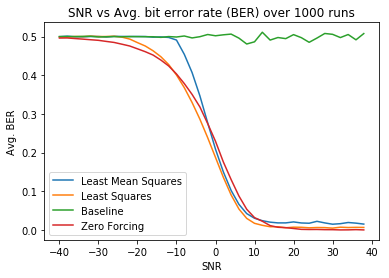

steps = 500
equalizer_order = 5
test_length = 1000
preamble_length = 100
random_starts = True
learning_rate = 0.01
channel_length = 2


In [84]:
# plot metric: snr
SNRs = np.arange(-40, 40, 2)
plot_metric("snr", SNRs, 
            runs=1000)

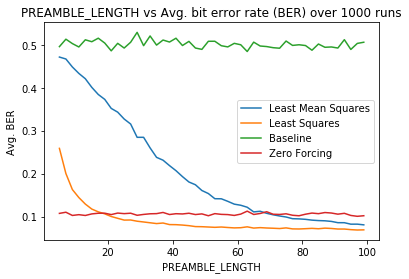

steps = 500
equalizer_order = 5
snr = 5
test_length = 1000
random_starts = True
learning_rate = 0.01
channel_length = 2


In [83]:
# plot metric: preamble length
preambles = np.arange(5, 100, 2)
plot_metric("preamble_length", preambles, runs=1000, equalizers={
                        'Baseline':Baseline,
                        'Zero Forcing':ZeroForcing,
                        'Least Mean Squares':LeastMeanSquares, 
                        'Least Squares':LeastSquares
                        })

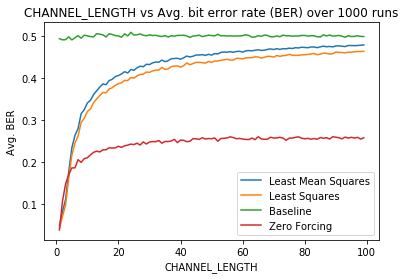

steps = 500
equalizer_order = 5
snr = 5
test_length = 1000
preamble_length = 100
random_starts = True
learning_rate = 0.01


In [82]:
# plot metric: channel length
channels = np.arange(1, 100, 1)
plot_metric("channel_length", channels , runs=1000)